In [1]:
import pandas as pd
import numpy as np

import altair as alt
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer, MissingIndicator
import fancyimpute as fimp

import datetime
from meteostat import Point, Hourly, Daily

#from pandas_profiling import ProfileReport
from scipy import stats

In [2]:
df = pd.read_csv('cneos_fireball_data.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 937 entries, 0 to 936
Data columns (total 10 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Peak Brightness Date/Time (UT)       937 non-null    object 
 1   Latitude (deg.)                      747 non-null    object 
 2   Longitude (deg.)                     747 non-null    object 
 3   Altitude (km)                        479 non-null    float64
 4   Velocity (km/s)                      279 non-null    float64
 5   vx                                   279 non-null    float64
 6   vy                                   279 non-null    float64
 7   vz                                   279 non-null    float64
 8   Total Radiated Energy (J)            937 non-null    float64
 9   Calculated Total Impact Energy (kt)  937 non-null    float64
dtypes: float64(7), object(3)
memory usage: 73.3+ KB


In [3]:
# ProfileReport(df, title='Fireball Report').to_file('load_report.html')

In [4]:
# Apply imputation


In [5]:
# splitting date and time
df['Peak Brightness Date/Time (UT)']= pd.to_datetime(df['Peak Brightness Date/Time (UT)'])

df['Date'] = pd.to_datetime(df['Peak Brightness Date/Time (UT)'].dt.date)
df['year'] = df['Peak Brightness Date/Time (UT)'].dt.year
df['quarter'] = df['Peak Brightness Date/Time (UT)'].dt.quarter
df['month'] = df['Peak Brightness Date/Time (UT)'].dt.month
df['day'] = df['Peak Brightness Date/Time (UT)'].dt.day
df['weekday'] = df['Peak Brightness Date/Time (UT)'].dt.weekday
#df['Time'] = df['Peak Brightness Date/Time (UT)'].dt.time
df['hour'] = df['Peak Brightness Date/Time (UT)'].dt.hour
df['minute'] = df['Peak Brightness Date/Time (UT)'].dt.minute
df['second'] = df['Peak Brightness Date/Time (UT)'].dt.second
df['Month'] = df['Peak Brightness Date/Time (UT)'].dt.strftime('%B')
# df['delta'] = (df['Peak Brightness Date/Time (UT)']-df['Peak Brightness Date/Time (UT)'].shift()).fillna(pd.to_datetime("00:00:00"))

In [6]:
# changing latitude and longitude to values
def lat(row):
    if row['Latitude (deg.)'] == row['Latitude (deg.)']:
        if row['Latitude (deg.)'][-1] == 'N':
            return float(row['Latitude (deg.)'][:-1])
        elif row['Latitude (deg.)'][-1] == 'S':
            return float('-'+(row['Latitude (deg.)'][:-1]))
    return np.nan

def long(row):
    if row['Longitude (deg.)'] == row['Longitude (deg.)']:
        if row['Longitude (deg.)'][-1] == 'E':
            return float(row['Longitude (deg.)'][:-1])
        elif row['Longitude (deg.)'][-1] == 'W':
            return float('-'+(row['Longitude (deg.)'][:-1]))
    return np.nan

df['Lat'] = df.apply(lambda row: lat(row), axis=1)
df['Long'] = df.apply(lambda row: long(row), axis=1)

In [7]:
df['vx2'] = df['vx']**2
df['vy2'] = df['vy']**2
df['vz2'] = df['vz']**2
df['vel2'] = df['Velocity (km/s)']**2

In [8]:
#getting climate data
start = datetime.datetime(2021,2,9)
end = datetime.datetime(2021,2,10)
Daily(Point(75.8, -92.8, 31000), start, end).fetch()

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 937 entries, 0 to 936
Data columns (total 26 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   Peak Brightness Date/Time (UT)       937 non-null    datetime64[ns]
 1   Latitude (deg.)                      747 non-null    object        
 2   Longitude (deg.)                     747 non-null    object        
 3   Altitude (km)                        479 non-null    float64       
 4   Velocity (km/s)                      279 non-null    float64       
 5   vx                                   279 non-null    float64       
 6   vy                                   279 non-null    float64       
 7   vz                                   279 non-null    float64       
 8   Total Radiated Energy (J)            937 non-null    float64       
 9   Calculated Total Impact Energy (kt)  937 non-null    float64       
 10  Date          

In [10]:
# ProfileReport(df, title='Fireball Report').to_file('fireball_report.html')

In [11]:
time_df = df[['year', 'quarter', 'month', 'day', 'weekday', 'hour', 'minute', 'second']]

In [12]:
selection = alt.selection(type='interval', encodings=['x'])

base = alt.Chart().mark_bar().encode(
    x=alt.X(alt.repeat('column'), type='quantitative'),
    y=alt.Y(aggregate='count', type='quantitative')
).properties(
    width=225,
    height=130
)
    
# gray background with selection
background = base.encode(
    color=alt.value('#ddd')
).add_selection(selection)

# blue highlights on the transformed data
highlight = base.transform_filter(selection)

line = alt.Chart().mark_rule(color='firebrick').encode(
    x=alt.X(alt.repeat('column'), aggregate='mean', type='quantitative'),
    size=alt.SizeValue(3)
).transform_filter(selection)

# layer the three charts & repeat
time = alt.layer(
    background,
    highlight,
    line,
    data=time_df
)

time_chrt = alt.vconcat(
    time.repeat(column=["year", "quarter", "month"]),
    time.repeat(column=["day", "weekday"]),
    time.repeat(column=["hour", "minute", "second"])
)

In [13]:
time_chrt

alt.VConcatChart(...)

In [14]:
time_chrt.save('time.json')
time_chrt.save('time.html')

In [15]:
scater_df = df[['Velocity (km/s)', 'vel2', 'vx2', 'vy', 'vy2', 'vz', 'vz2']]

In [16]:
scatter = alt.Chart(scater_df).mark_circle().encode(
    alt.X(alt.repeat("column"), type='quantitative'),
    alt.Y(alt.repeat("row"), type='quantitative'),
    color='Origin:N'
).properties(
    width=150,
    height=150
).repeat(
    row=['Velocity (km/s)', 'vel2', 'vx2', 'vy2', 'vz2'],
    column=['Velocity (km/s)', 'vel2', 'vx2', 'vy2', 'vz2']
).interactive()

In [17]:
scatter.save('scatter.json')
scatter.save('scatter.html')

In [101]:
df['energy_log'] = np.log10(df['Calculated Total Impact Energy (kt)'])
world_df = df[['Peak Brightness Date/Time (UT)', 'Latitude (deg.)', 'Longitude (deg.)', 'Altitude (km)', 'Velocity (km/s)','Total Radiated Energy (J)', 'Lat', 'Long', 'energy_log']]

In [96]:
from vega_datasets import data
countries = alt.topo_feature(data.world_110m.url, 'countries')

base = alt.Chart(countries).mark_geoshape(
    fill='lightgray',
    stroke='white'
).project(
    "equirectangular"
).properties(
    width=500,
    height=300
)

In [110]:
points = alt.Chart(df).mark_circle(opacity=0.7).encode(
    longitude='Long:Q',
    latitude='Lat:Q',
    size = 'energy_log:Q',
    color = alt.Color('energy_log', scale = alt.Scale(scheme = 'reds')),
    tooltip=['Peak Brightness Date/Time (UT)', 'Latitude (deg.)', 'Longitude (deg.)', 'Altitude (km)', 'Velocity (km/s)','Total Radiated Energy (J)']
)

In [111]:
world = base + points
world

alt.LayerChart(...)

In [112]:
world.save('world.json')
world.save('world.html')

In [18]:
df

,Peak Brightness Date/Time (UT),Latitude (deg.),Longitude (deg.),Altitude (km),Velocity (km/s),vx,vy,vz,Total Radiated Energy (J),Calculated Total Impact Energy (kt),...,hour,minute,second,Month,Lat,Long,vx2,vy2,vz2,vel2
0,2022-11-20 15:35:21,17.0S,95.7W,50.0,NaN,NaN,NaN,NaN,3.300000e+10,0.110,...,15,35,21,November,-17.0,-95.7,NaN,NaN,NaN,NaN
1,2022-11-20 13:53:54,15.0N,109.7W,26.0,21.7,9.0,12.3,15.4,3.400000e+10,0.120,...,13,53,54,November,15.0,-109.7,81.0,151.29,237.16,470.89
2,2022-11-08 08:54:01,77.2N,93.2W,41.0,NaN,NaN,NaN,NaN,3.900000e+10,0.130,...,8,54,1,November,77.2,-93.2,NaN,NaN,NaN,NaN
3,2022-10-28 17:40:11,7.1N,118.9W,45.0,NaN,NaN,NaN,NaN,4.700000e+10,0.160,...,17,40,11,October,7.1,-118.9,NaN,NaN,NaN,NaN
4,2022-10-20 20:55:07,26.6N,165.1E,65.6,NaN,NaN,NaN,NaN,4.700000e+10,0.160,...,20,55,7,October,26.6,165.1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
932,1993-11-29 17:48:41,26.5N,78.3E,NaN,NaN,NaN,NaN,NaN,2.600000e+10,0.092,...,17,48,41,November,26.5,78.3,NaN,NaN,NaN,NaN
933,1993-10-31 03:39:27,51.3N,100.9W,NaN,NaN,NaN,NaN,NaN,4.000000e+10,0.130,...,3,39,27,October,51.3,-100.9,NaN,NaN,NaN,NaN
934,1991-10-04 09:22:47,78.7N,6.3E,NaN,NaN,NaN,NaN,NaN,5.500000e+11,1.400,...,9,22,47,October,78.7,6.3,NaN,NaN,NaN,NaN
935,1990-10-01 03:51:47,7.5N,142.8E,NaN,NaN,NaN,NaN,NaN,2.500000e+12,5.200,...,3,51,47,October,7.5,142.8,NaN,NaN,NaN,NaN


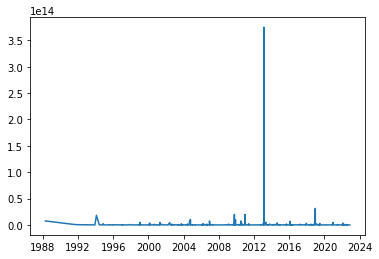

In [19]:
plt.plot(df['Peak Brightness Date/Time (UT)'], df['Total Radiated Energy (J)'])

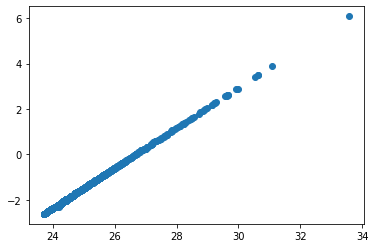

In [20]:
plt.scatter(np.log(df['Total Radiated Energy (J)']), np.log(df['Calculated Total Impact Energy (kt)']))

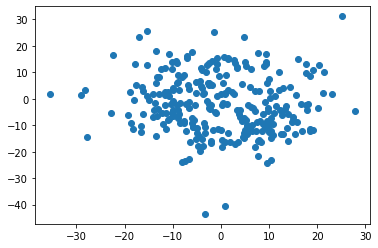

In [21]:
plt.scatter(df['vx'], df['vy'])

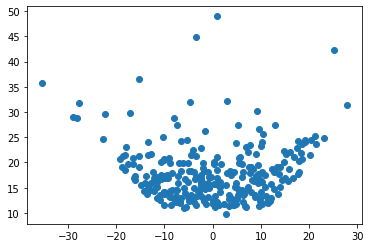

In [22]:
plt.scatter(df['vx'], df['Velocity (km/s)'])

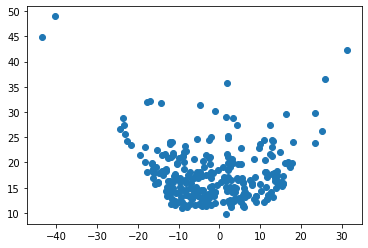

In [23]:
plt.scatter(df['vy'], df['Velocity (km/s)'])

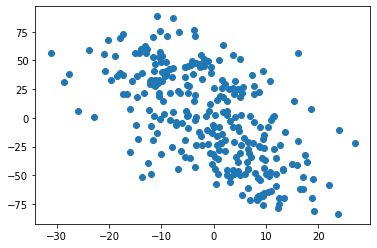

In [24]:
plt.scatter(df['vz'], df['Lat'])

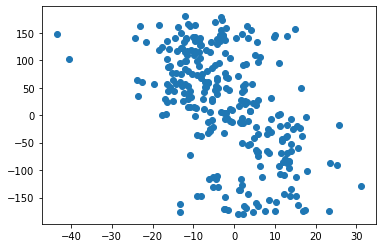

In [25]:
plt.scatter(df['vy'], df['Long'])

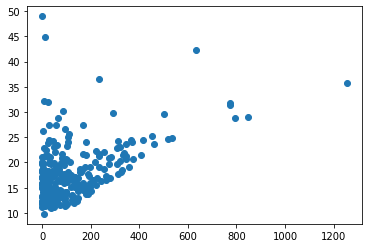

In [26]:
plt.scatter(df['vx2'], df['Velocity (km/s)'])

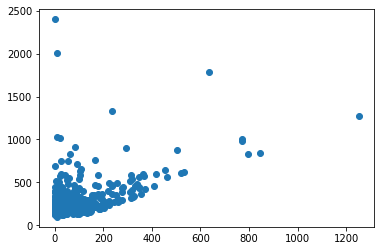

In [27]:
plt.scatter(df['vx2'], df['vel2'])

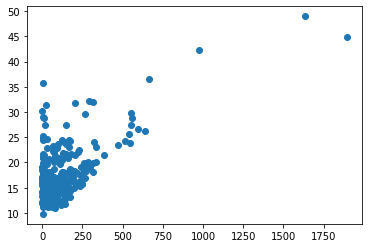

In [28]:
plt.scatter(df['vy2'], df['Velocity (km/s)'])

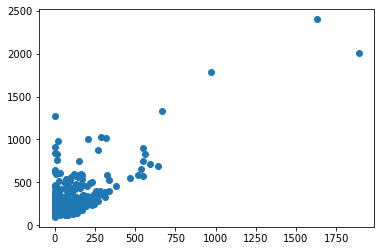

In [29]:
plt.scatter(df['vy2'], df['vel2'])

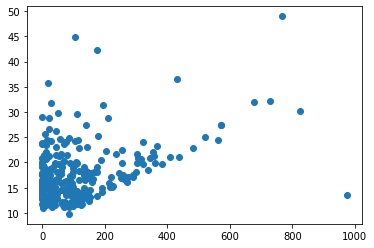

In [30]:
plt.scatter(df['vz2'], df['Velocity (km/s)'])

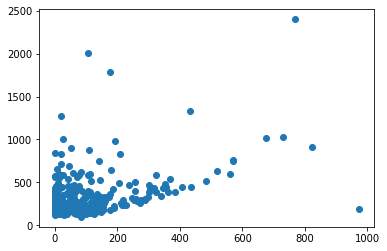

In [31]:
plt.scatter(df['vz2'], df['vel2'])

In [32]:
df2 = df[::-1].reset_index()

In [33]:
df2

,index,Peak Brightness Date/Time (UT),Latitude (deg.),Longitude (deg.),Altitude (km),Velocity (km/s),vx,vy,vz,Total Radiated Energy (J),...,hour,minute,second,Month,Lat,Long,vx2,vy2,vz2,vel2
0,936,1988-04-15 03:03:10,4.1S,124.3E,NaN,NaN,NaN,NaN,NaN,7.580000e+12,...,3,3,10,April,-4.1,124.3,NaN,NaN,NaN,NaN
1,935,1990-10-01 03:51:47,7.5N,142.8E,NaN,NaN,NaN,NaN,NaN,2.500000e+12,...,3,51,47,October,7.5,142.8,NaN,NaN,NaN,NaN
2,934,1991-10-04 09:22:47,78.7N,6.3E,NaN,NaN,NaN,NaN,NaN,5.500000e+11,...,9,22,47,October,78.7,6.3,NaN,NaN,NaN,NaN
3,933,1993-10-31 03:39:27,51.3N,100.9W,NaN,NaN,NaN,NaN,NaN,4.000000e+10,...,3,39,27,October,51.3,-100.9,NaN,NaN,NaN,NaN
4,932,1993-11-29 17:48:41,26.5N,78.3E,NaN,NaN,NaN,NaN,NaN,2.600000e+10,...,17,48,41,November,26.5,78.3,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
932,4,2022-10-20 20:55:07,26.6N,165.1E,65.6,NaN,NaN,NaN,NaN,4.700000e+10,...,20,55,7,October,26.6,165.1,NaN,NaN,NaN,NaN
933,3,2022-10-28 17:40:11,7.1N,118.9W,45.0,NaN,NaN,NaN,NaN,4.700000e+10,...,17,40,11,October,7.1,-118.9,NaN,NaN,NaN,NaN
934,2,2022-11-08 08:54:01,77.2N,93.2W,41.0,NaN,NaN,NaN,NaN,3.900000e+10,...,8,54,1,November,77.2,-93.2,NaN,NaN,NaN,NaN
935,1,2022-11-20 13:53:54,15.0N,109.7W,26.0,21.7,9.0,12.3,15.4,3.400000e+10,...,13,53,54,November,15.0,-109.7,81.0,151.29,237.16,470.89


In [34]:
delta = (df2['Peak Brightness Date/Time (UT)']-df2['Peak Brightness Date/Time (UT)'].shift()).fillna(pd.Timedelta('0 days'))
delta_d = delta.dt.days

In [35]:
delta

0       0 days 00:00:00
1     899 days 00:48:37
2     368 days 05:31:00
3     757 days 18:16:40
4      29 days 14:09:14
             ...       
932    35 days 18:06:05
933     7 days 20:45:04
934    10 days 15:13:50
935    12 days 04:59:53
936     0 days 01:41:27
Name: Peak Brightness Date/Time (UT), Length: 937, dtype: timedelta64[ns]

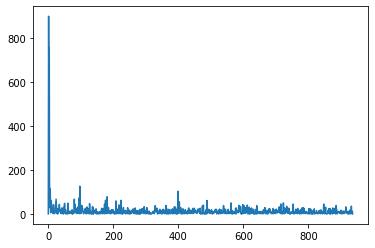

In [36]:
plt.plot(delta_d)

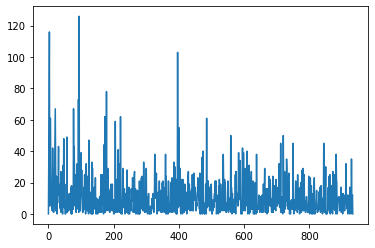

In [37]:
delta2 = pd.concat([delta[:1],delta[4:]]).reset_index(drop=True)
delta2_d = delta2.dt.days
plt.plot(delta2_d)

In [38]:
print(delta.describe())
print(delta_d.describe())
print(delta2.describe())
print(delta2_d.describe())

count                           937
mean     13 days 11:41:35.550693703
std      41 days 15:18:52.885356860
min                 0 days 00:00:00
25%                 2 days 20:32:24
50%                 7 days 17:00:11
75%                15 days 11:52:12
max               899 days 00:48:37
Name: Peak Brightness Date/Time (UT), dtype: object
count    937.000000
mean      12.991462
std       41.648585
min        0.000000
25%        2.000000
50%        7.000000
75%       15.000000
max      899.000000
Name: Peak Brightness Date/Time (UT), dtype: float64
count                           934
mean     11 days 08:41:52.798715203
std      12 days 20:55:05.182838875
min                 0 days 00:00:00
25%          2 days 20:19:24.750000
50%                 7 days 15:26:10
75%         15 days 07:17:10.500000
max               126 days 05:08:39
Name: Peak Brightness Date/Time (UT), dtype: object
count    934.000000
mean      10.866167
std       12.880033
min        0.000000
25%        2.000000
50%    

In [39]:
# normal distribution
# For unknown variance, check n > 40, with σ replaced with S
n1 = 929
n2 = 926

# H0: μ = 35  H1 : μ ̸= 35 
# R  = {|Z| ≥ Zα/2}
# Test Statistic: Z = (X−35) / (σ/√929) ∼N(0,1)

In [40]:
lambda1 = delta.mean()
lambda2 = delta2.mean()
lambda1_d = delta_d.mean()
lambda2_d = delta2_d.mean()

In [41]:
print(lambda1_d +np.array([+1, -1])*(stats.norm.ppf(1-.05/2)*((lambda1_d/n1)**0.5)))
print(lambda2_d +np.array([+1, -1])*(stats.norm.ppf(1-.05/2)*((lambda2_d/n2)**0.5)))

[13.22323853 12.75968569]
[11.07848208 10.65385197]


In [42]:
# poisson distribution
stats.poisson.stats(lambda2_d)

(array(10.86616702), array(10.86616702))

In [43]:
#1 - ((np.exp(-time*lambda2_d))*(time*lambda2_d)**0)

In [44]:
delta2_d.value_counts()

0      91
1      86
2      67
3      56
5      52
       ..
49      1
48      1
47      1
37      1
126     1
Name: Peak Brightness Date/Time (UT), Length: 61, dtype: int64

(array([516., 218., 111.,  45.,  16.,  14.,   1.,   8.,   1.,   1.,   0.,
          0.,   1.,   1.,   1.]),
 array([  0. ,   8.4,  16.8,  25.2,  33.6,  42. ,  50.4,  58.8,  67.2,
         75.6,  84. ,  92.4, 100.8, 109.2, 117.6, 126. ]),
 <BarContainer object of 15 artists>)

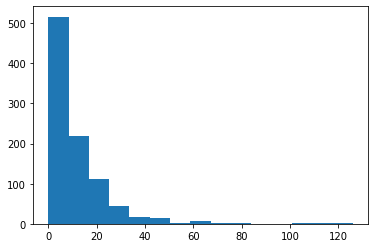

In [45]:
plt.hist(delta2_d,15)

In [46]:
curr_d = datetime.date.today()
diff_d = (curr_d - df['Date'][0].date()).days

In [47]:
diff_d

19

In [48]:
print(sum(delta,datetime.timedelta()))
print(sum(delta_d))
print(sum(delta2,datetime.timedelta()))
print(sum(delta2_d))

12637 days 12:32:11
12173
10612 days 11:55:54
10149


In [49]:
lambda3 = 929/sum(delta_d)
lambda4 = 926/sum(delta2_d)
print(lambda3)
print(lambda4)

0.07631643801856568
0.09124051630702533


In [50]:
print(lambda3 +np.array([+1, -1])*(stats.norm.ppf(1-.05/2)*((lambda3/n1)**0.5)))
print(lambda4 +np.array([+1, -1])*(stats.norm.ppf(1-.05/2)*((lambda4/n2)**0.5)))

[0.09408079 0.05855209]
[0.11069575 0.07178528]


In [51]:
# at least one fireball appearing
print(1 - stats.poisson.pmf(0,lambda4*11))

# exactly that number appearing
print(stats.poisson.pmf(0,lambda4))


print(1 - stats.poisson.cdf(11,lambda4))

0.6334592875499646
0.9127981416572417
0.0


In [52]:
df['Date']

0     2022-11-20
1     2022-11-20
2     2022-11-08
3     2022-10-28
4     2022-10-20
         ...    
932   1993-11-29
933   1993-10-31
934   1991-10-04
935   1990-10-01
936   1988-04-15
Name: Date, Length: 937, dtype: datetime64[ns]

In [53]:
df.corr().style.background_gradient(cmap='coolwarm', axis=None)

,Altitude (km),Velocity (km/s),vx,vy,vz,Total Radiated Energy (J),Calculated Total Impact Energy (kt),year,quarter,month,day,weekday,hour,minute,second,Lat,Long,vx2,vy2,vz2,vel2
Altitude (km),1.000000,0.108386,-0.073145,0.047922,-0.063870,-0.072329,-0.080187,-0.090455,-0.004462,0.009716,0.004716,-0.023182,-0.028561,-0.016336,-0.047515,0.000562,-0.087144,0.064136,0.072588,0.022422,0.118941
Velocity (km/s),0.108386,1.000000,0.000201,-0.096691,-0.191673,0.006016,0.005496,0.030832,-0.024310,-0.018948,-0.014762,0.008995,-0.010636,-0.035541,0.026582,0.099513,0.044220,0.479177,0.633725,0.402226,0.970661
vx,-0.073145,0.000201,1.000000,-0.089464,0.000727,0.083485,0.088585,-0.119436,0.153079,0.163520,-0.052365,0.126212,-0.077226,0.025927,-0.020230,-0.067278,0.116399,-0.085890,0.040348,0.041355,-0.008824
vy,0.047922,-0.096691,-0.089464,1.000000,0.090484,-0.063905,-0.063698,-0.001173,0.102881,0.101490,0.052072,0.012178,0.100895,0.054045,0.087007,0.019866,-0.511867,0.106004,-0.221385,-0.042056,-0.119808
vz,-0.063870,-0.191673,0.000727,0.090484,1.000000,-0.020053,-0.022611,-0.034998,-0.019068,-0.015886,0.047390,0.060383,0.021320,-0.013428,-0.023558,-0.601014,-0.084285,-0.019270,-0.170852,-0.206875,-0.213704
Total Radiated Energy (J),-0.072329,0.006016,0.083485,-0.063905,-0.020053,1.000000,0.998163,0.012691,-0.035835,-0.033906,-0.007467,0.016774,-0.030418,-0.010957,-0.008400,0.058767,0.034400,0.019004,0.012311,-0.012911,-0.002992
Calculated Total Impact Energy (kt),-0.080187,0.005496,0.088585,-0.063698,-0.022611,0.998163,1.000000,0.010478,-0.033198,-0.031114,-0.010454,0.017001,-0.026961,-0.008371,-0.013657,0.059697,0.039935,0.019902,0.010955,-0.003230,-0.003638
year,-0.090455,0.030832,-0.119436,-0.001173,-0.034998,0.012691,0.010478,1.000000,-0.055481,-0.055605,0.128575,-0.027488,0.004029,0.046592,0.023026,-0.018209,-0.046621,0.038911,0.003555,0.007315,0.025661
quarter,-0.004462,-0.024310,0.153079,0.102881,-0.019068,-0.035835,-0.033198,-0.055481,1.000000,0.972316,0.036268,-0.031624,-0.016659,0.026266,-0.042698,-0.034818,-0.019968,-0.036528,-0.051473,0.077606,-0.033165
month,0.009716,-0.018948,0.163520,0.101490,-0.015886,-0.033906,-0.031114,-0.055605,0.972316,1.000000,0.032928,-0.021652,-0.008583,0.036193,-0.030561,-0.034349,-0.011000,-0.013647,-0.067498,0.084099,-0.030571


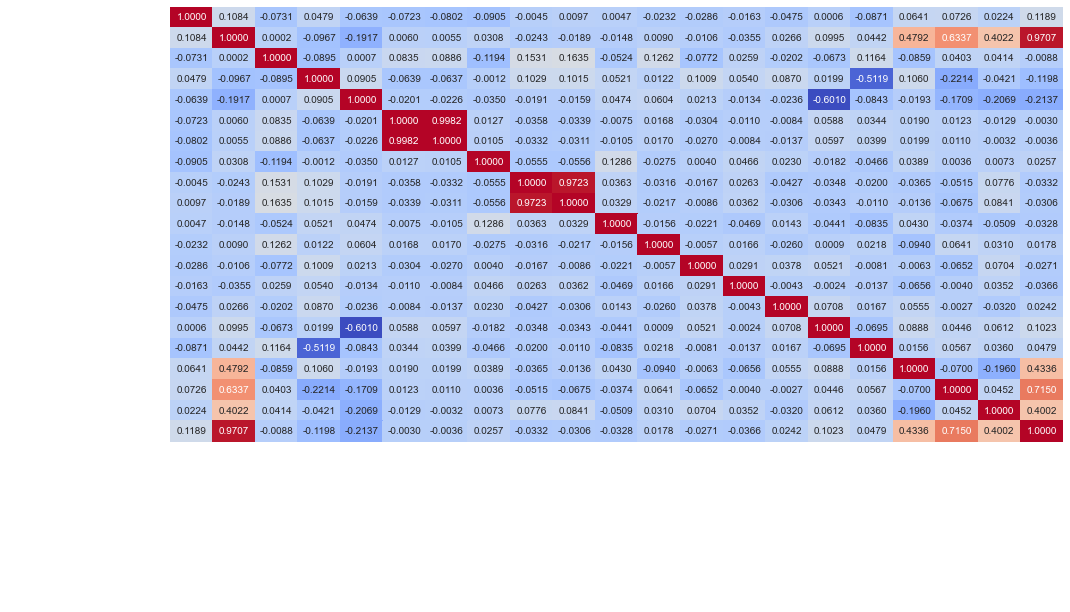

In [58]:
import seaborn as sns
custom_style = {'axes.labelcolor': 'white',
                'xtick.color': 'white',
                'ytick.color': 'white'}
plt.rcParams['savefig.transparent'] = True
sns.set_style("darkgrid", rc=custom_style)
fig, ax = plt.subplots(figsize = (16,8))
sns.heatmap(df.corr(), annot=True, fmt='.4f', 
            cmap=plt.get_cmap('coolwarm'), cbar=False, ax=ax)
ax.set_yticklabels(ax.get_yticklabels(), rotation="horizontal")
plt.savefig('corr.png', bbox_inches='tight', pad_inches=0.0)

In [55]:
df.to_csv("fire_df.csv")